# Time-Frequency analysis
In this script we want to read in the time-frequency data, plot some spectrograms where each point is estimated using an LME. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.io import loadmat,savemat
from scipy.signal import deconvolve, savgol_filter

import os
os.environ['R_HOME'] = 'C:\\Users\\j_gav\\anaconda3\\envs\\analysis\\lib\\R'

from plotnine import *
# import plotly

# import h5py

from scipy.spatial import KDTree, ConvexHull
from scipy.ndimage.interpolation import shift

# import alphashape


from utils import *

from pymer4 import Lmer, Lm

# import jenkspy

## Figure 5: Beta-Band analysis + spectrograms

In [6]:
df = pd.read_csv('./data/df_tfLong_redo.csv')

In [7]:
df

,Unnamed: 0,time,size,size_base,size_shift,size_base_shift,size_base_div,isprobe,isfti,wait_time,...,fti_time,condition,brief,subject,trial,Cz,F1,C3,P1,freq
0,0,-2.00,778.174551,71.094657,718.598007,11.518114,3.235070,0,0,2.901075,...,NaN,RP,True,33702,0,4.695509,0.792535,1.375517,3.423108,0.5
1,1,-1.95,781.790050,74.710157,719.430012,12.350118,3.399588,0,0,2.901075,...,NaN,RP,True,33702,0,4.507707,0.860573,1.367938,3.446762,0.5
2,2,-1.90,772.846189,65.766296,747.369339,40.289446,2.992610,0,0,2.901075,...,NaN,RP,True,33702,0,4.321620,0.995572,1.347290,3.427738,0.5
3,3,-1.85,764.043062,56.963169,773.386227,66.306334,2.592035,0,0,2.901075,...,NaN,RP,True,33702,0,4.070468,1.163255,1.359330,3.413190,0.5
4,4,-1.80,755.311005,48.231112,794.477396,87.397503,2.194694,0,0,2.901075,...,NaN,RP,True,33702,0,3.821433,1.327381,1.377897,3.364183,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10504195,56,0.80,497.462513,-105.456170,498.319217,-104.599465,-8.009888,0,0,3.559768,...,NaN,RP,True,33725,179,0.001115,0.093410,0.010687,0.011751,40.0
10504196,57,0.85,512.821678,-90.097005,500.678251,-102.240432,-6.843288,0,0,3.559768,...,NaN,RP,True,33725,179,0.000092,0.104674,0.004303,0.006332,40.0
10504197,58,0.90,526.893457,-76.025225,501.095534,-101.823149,-5.774470,0,0,3.559768,...,NaN,RP,True,33725,179,0.000112,0.069768,0.002067,0.003297,40.0
10504198,59,0.95,541.540112,-61.378571,499.398751,-103.519932,-4.661989,0,0,3.559768,...,NaN,RP,True,33725,179,0.000833,0.017470,0.005710,0.003455,40.0


In [427]:
## Run through and for each time/frequency/channel combination, estimate differences in power using a linear mixed-effects model.

frames = []
df_temp = df.loc[(df.time.between(-2,1)) & (df.condition.isin(['RP','FTI','Hit','Miss'])),['C3','time','condition','subject','freq']].copy()


for time in df_temp.time.unique():
    if time % 1 == 0:
        print(time)
    for freq in df_temp.freq.unique():
        df_this = df_temp.loc[(df_temp.time.values==time)&(df_temp.freq.values==freq),['C3','condition','subject']].copy().dropna()
        
        betas = []
        pvals = []
        tstat = []
        
        model = Lmer('C3~condition+(1|subject)',data=df_this)

        model.fit(factors={'condition':['Miss','Hit','RP','FTI']},summary=False)

        marginal_estimates, comparisons = model.post_hoc(
            marginal_vars="condition"#, grouping_vars=["precueType"]
        )

        df_tf = marginal_estimates.copy()
        df_tf['time']=time
        df_tf['frequency'] = freq
        
        frames.append(df_tf)
    
df_tfEst = pd.concat(frames)

print('\n\n\nSaving to CSV')
df_tfEst.to_csv('processed_data/df_C3_spectrogram.csv',index=False)

-2.0
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method for family of 6 estimates
P-values adjusted by tukey method f

In [32]:
df_tfEst = pd.read_csv('./data/df_C3_spectrogram.csv')

In [7]:
df_tfEst

,condition,Estimate,2.5_ci,97.5_ci,SE,DF,time,frequency
0,Miss,3.402,0.629,6.175,1.355,28.525,-2.0,0.500000
1,Hit,3.736,0.876,6.596,1.406,33.046,-2.0,0.500000
2,RP,3.749,1.077,6.421,1.294,23.744,-2.0,0.500000
3,FTI,5.662,2.519,8.804,1.565,50.727,-2.0,0.500000
4,Miss,1.144,0.459,1.830,0.334,26.674,-2.0,1.512821
...,...,...,...,...,...,...,...,...
9755,FTI,0.016,0.001,0.031,0.007,59.896,1.0,38.987179
9756,Miss,0.012,0.004,0.020,0.004,28.954,1.0,40.000000
9757,Hit,0.011,0.003,0.019,0.004,33.840,1.0,40.000000
9758,RP,0.014,0.007,0.022,0.004,23.815,1.0,40.000000


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/tfr/betaDS_Miss.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/tfr/betaDS_Miss.png


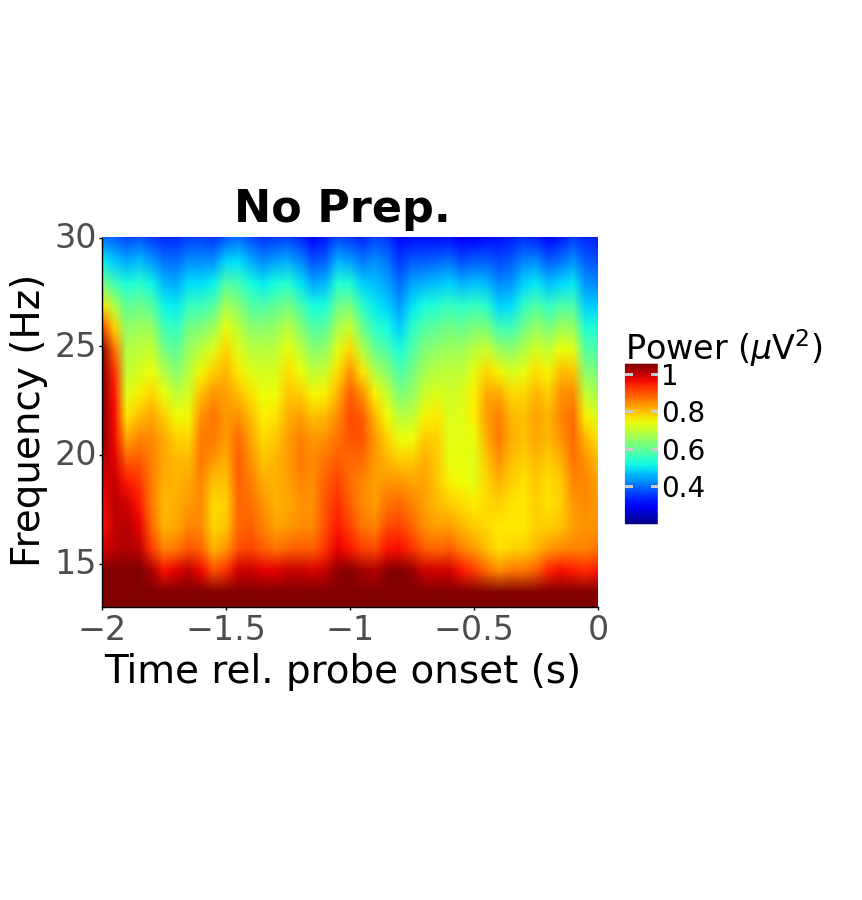

<ggplot: (439356805)>

In [28]:
condition='Miss'

chan_ROI = {
    'Miss':'No Prep.',
    'Hit':'Prep.',
    'RP':'Movement',
    'FTI':'Failure-to-Inhibit'
}

df_tfEst = pd.read_csv('processed_data/df_C3_spectrogram.csv')

df_temp = df_tfEst[(df_tfEst.time.between(-1,0)) & (df_tfEst.frequency.between(14,30))].copy()





# cmax = np.max(df_temp.loc[df_temp.condition.isin([condition]),'Estimate'].values)
# cmin = np.min(df_temp.loc[df_temp.condition.isin([condition]),'Estimate'].values)

cmax = np.max(df_temp['Estimate'].values)
cmin = np.min(df_temp['Estimate'].values)

df_temp = df_tfEst[df_tfEst.condition.isin([condition])].copy()


p = (ggplot(df_temp,aes(x='time',y='frequency',fill='Estimate')) +
     geom_raster(interpolate=True)+
     ggtitle(f"{chan_ROI[condition]}")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
#      scale_fill_gradient2(name='Power',
# # #                             high = '#a6212c', # More muted
# # #                           low = '#212ca6',
#                           high = '#FF4000', # More vibrant
#                           low = '#00E1FF',
#                           mid = 'white',
#                           na_value='white',
# #                           mid='#7a6977',
# #                           na_value='#7a6977',
#                           limits=(cmin,cmax)) +
     scale_fill_cmap('jet',name='Power ($\mu$V$^2$)',limits=(cmax,cmin))+
     scale_x_continuous(name='Time rel. probe onset (s)') +
     scale_y_continuous(name='Frequency (Hz)') +
     coord_cartesian(xlim = (-2,0.), ylim = (13,30),expand=False)+
     theme_bw() +
     theme(axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=24),
           axis_ticks_length = 2,
           axis_title = element_text(size=28),
           plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=20),
           legend_title = element_text(size=24),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
#            figure_size = (8,5)
#            plot_margin = 0.01
           
        )
    )

# p.save(savepath+f"tfr/betaDS_{condition}.svg")
# p.save(savepath+f"tfr/betaDS_{condition}.png")


p

### Beta power in 250 ms prior to probe onset/movement
Specify the frequency between 12 and 20 for low beta, 20 and 30 for high beta.

In [11]:
df_temp = df[(df.time.between(-0.25,0)) & (df.freq.between(12,20)) & (df.condition.isin(['RP','FTI','Hit','Miss']))].groupby(['subject','trial','condition'],as_index=False).mean()

# df_temp.to_csv('./data/betapower_avg.csv')

In [12]:
df_temp

,subject,trial,condition,Unnamed: 0,time,size,size_base,size_shift,size_base_shift,size_base_div,...,isfti,wait_time,probe_time,fti_time,brief,Cz,F1,C3,P1,freq
0,33702,0,RP,37.5,-0.125,730.330960,23.251067,705.547171,-1.532723,1.058009,...,0.0,2.901075,NaN,NaN,True,1.721636,2.637450,0.909960,1.497140,16.198718
1,33702,2,RP,37.5,-0.125,722.536326,48.665395,771.412918,97.541987,2.440861,...,0.0,4.269728,NaN,NaN,False,0.372241,0.802667,0.375626,2.574156,16.198718
2,33702,3,RP,37.5,-0.125,645.831809,39.553981,631.231095,24.953267,3.924641,...,0.0,4.519402,NaN,NaN,False,0.371541,0.457544,0.456688,1.606009,16.198718
3,33702,4,Miss,37.5,-0.125,645.542925,12.770168,659.346149,26.573391,0.721276,...,0.0,NaN,3.725612,NaN,False,0.756357,1.216307,0.634253,1.000934,16.198718
4,33702,5,RP,37.5,-0.125,687.435328,36.465314,662.569299,11.599285,0.784945,...,0.0,3.194155,NaN,NaN,True,1.079057,0.345928,0.279680,1.572316,16.198718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,33725,175,RP,37.5,-0.125,855.661714,132.764114,898.332285,175.434685,8.336590,...,0.0,3.311247,NaN,NaN,True,0.109637,0.572254,0.103039,0.131147,16.198718
4133,33725,176,RP,37.5,-0.125,685.287075,32.621502,713.418173,60.752600,3.127604,...,0.0,4.831753,NaN,NaN,False,0.203681,0.854284,0.274292,0.477839,16.198718
4134,33725,177,Miss,37.5,-0.125,772.702651,18.008029,728.484611,-26.210011,0.728484,...,0.0,NaN,2.685961,NaN,False,0.320056,0.253866,0.182317,0.140214,16.198718
4135,33725,178,RP,37.5,-0.125,639.559149,-71.825110,545.292680,-166.091578,-12.798133,...,0.0,3.901750,NaN,NaN,False,2.440248,1.095185,0.913183,1.159734,16.198718


In [13]:
model = Lmer('C3~condition+(1|subject)',data=df_temp)

model.fit(factors={'condition':['Miss','Hit','RP','FTI']},summary=False)

marginal_estimates, comparisons = model.post_hoc(
    marginal_vars="condition",p_adjust='tukey'#, grouping_vars=["precueType"]
)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

P-values adjusted by tukey method for family of 6 estimates


In [14]:
marginal_estimates

,condition,Estimate,2.5_ci,97.5_ci,SE,DF
0,Miss,0.945,0.758,1.132,0.091,26.270
1,Hit,0.806,0.616,0.997,0.093,28.855
2,RP,0.755,0.572,0.937,0.088,23.445
3,FTI,0.639,0.436,0.841,0.100,38.448


In [15]:
comparisons

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
0,Miss - Hit,0.139,0.035,0.243,0.041,3979.620,3.421,0.004,**
1,Miss - RP,0.191,0.115,0.266,0.030,3987.427,6.459,0.000,***
2,Miss - FTI,0.306,0.166,0.447,0.055,3974.594,5.591,0.000,***
3,Hit - RP,0.052,-0.039,0.143,0.035,3982.406,1.467,0.458,
4,Hit - FTI,0.168,0.017,0.319,0.059,3975.894,2.857,0.022,*
5,RP - FTI,0.116,-0.014,0.246,0.051,3972.794,2.287,0.101,


In [38]:
# df

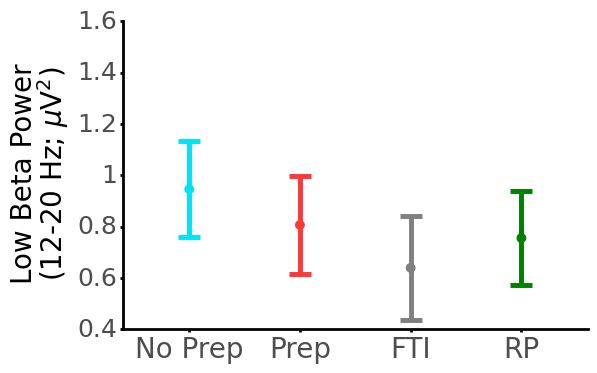

<ggplot: (167216612590)>

In [16]:
## Error Bars Only

df2use = marginal_estimates.copy()

df2use.rename({'2.5_ci':'CIlow','97.5_ci':'CIhigh'},axis=1,inplace=True)

p = (ggplot(df2use,aes(x='condition',y='Estimate',color='condition',fill='condition',ymin='CIlow',ymax='CIhigh')) +
     scale_x_discrete(name='Condition',limits=['Miss','Hit','FTI','RP'],labels=['No Prep','Prep','FTI','RP']) +
     geom_errorbar(size=2,width=0.2) +
     geom_point(size=3) +
#  scale_y_continuous(breaks=np.arange(-15,36,5),limits=(-15,38)) +
   scale_y_continuous(name='Low Beta Power\n(12-20 Hz; $\mu$V$^2$)',limits=(0.4,1.6),breaks=np.arange(0,1.61,0.2),expand=(0.,0.)) +
#     scale_y_continuous(name='High Beta Power\n(20-30 Hz; $\mu$V$^2$)',limits=(0,1.2),breaks=np.arange(0,1.61,0.2),expand=(0.,0.)) +

   scale_color_manual(name='Condition',values=['gray','#FF3838','#00E3F7','green'])+
     scale_fill_manual(values=['gray','#FF3838','#00E3F7','green']) +
#  labs(title='Anticipatory Pupil Dilations') +
 theme_classic() +
   theme(legend_position='none',
        axis_text_y = element_text(size=18),
     axis_text_x = element_text(size=20),

       axis_ticks_length = 2,
       axis_title_y = element_text(size=20),
         axis_title_x = element_blank(),
         axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
        figure_size = (6,4)) 
)

# p.save(savepath+'eeg/betaL_amplitudes_errbar.svg')
# p.save(savepath+'eeg/betaL_amplitudes_errbar.png')

p

## Figure 6: Exploratory comparison of Prep vs No-Prep, probe (Prep & No Prep) vs movement

### 6A: Prep vs No-Prep

Code for analysis below, skip to just do plotting

In [19]:
df = pd.read_csv('./data/df_tfLong_redo.csv')

In [300]:
df

,Unnamed: 0,time,size,size_base,size_shift,size_base_shift,size_base_div,isprobe,isfti,wait_time,...,fti_time,condition,brief,subject,trial,Cz,F1,C3,P1,freq
7350,30,-0.50,584.538977,-48.233780,648.395320,15.622563,-2.724309,1,0,NaN,...,NaN,Miss,False,33702,4,1.007218,4.167233,1.263488,7.867257,0.5
7351,31,-0.45,600.326977,-32.445780,649.392602,16.619845,-1.832581,1,0,NaN,...,NaN,Miss,False,33702,4,0.958238,4.342446,1.492027,8.205469,0.5
7352,32,-0.40,609.351181,-23.421576,654.465362,21.692605,-1.322882,1,0,NaN,...,NaN,Miss,False,33702,4,0.964227,4.510440,1.731075,8.453396,0.5
7353,33,-0.35,618.276577,-14.496180,654.958727,22.185969,-0.818764,1,0,NaN,...,NaN,Miss,False,33702,4,0.857432,4.707097,2.007832,8.700661,0.5
7354,34,-0.30,626.515289,-6.257469,653.870053,21.097296,-0.353430,1,0,NaN,...,NaN,Miss,False,33702,4,0.780534,4.926012,2.293078,8.571723,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089395,56,0.80,777.159847,22.465225,662.779406,-91.915216,0.908792,1,0,NaN,...,NaN,Miss,False,33725,177,0.012256,0.122252,0.041583,0.009277,40.0
10089396,57,0.85,782.926177,28.231555,689.291846,-65.402776,1.142059,1,0,NaN,...,NaN,Miss,False,33725,177,0.005385,0.086415,0.012297,0.003517,40.0
10089397,58,0.90,789.848638,35.154016,715.151290,-39.543331,1.422095,1,0,NaN,...,NaN,Miss,False,33725,177,0.003721,0.084268,0.009140,0.000963,40.0
10089398,59,0.95,794.991218,40.296597,725.364152,-29.330470,1.630129,1,0,NaN,...,NaN,Miss,False,33725,177,0.000886,0.016535,0.003030,0.005186,40.0


In [302]:
## Run through and for each time/frequency/channel combination, estimate differences in power using a linear mixed-effects model.

frames = []
df_temp = df[(df.time.between(-0.5,1)) & (df.condition.isin(['Hit','Miss']))]


for time in df_temp.time.unique():
    print(time)
    for freq in df_temp.freq.unique():
        df_this = df_temp.loc[(df_temp.time==time)&(df_temp.freq==freq),chans2use+['time','condition','subject']].copy().dropna()
        
        betas = []
        pvals = []
        tstat = []
        chans = []
        for channel in chans2use:
#         for channel in ['Cz']:
        #     df_temp['logPow'] = np.log(df_temp[channel].values)
        #     model = Lmer('logPow~condition+(1|subject)',data=df_temp,)
            model = Lmer(channel+'~condition+(1|subject)',data=df_this)

            model.fit(factors={'condition':['Miss','Hit']},summary=False)

            betas.append(model.coefs['Estimate'][1])
            pvals.append(model.coefs['P-val'][1])
            tstat.append(model.coefs['T-stat'][1])
            chans.append(channel)

        df_tf = pd.DataFrame({
            'channel':chans,
            'betas':betas,
            'pvals':pvals,
            'tstat':tstat,
        })
        df_tf['time']=time
        df_tf['frequency'] = freq
        
        frames.append(df_tf)
    
df_tfEst = pd.concat(frames)

print('\n\n\nSaving to CSV')
df_tfEst.to_csv('processed_data/df_tfEst_redo.csv',index=False)

-0.5
-0.45
-0.4000000000000001
-0.3500000000000001
-0.30000000000000004
-0.25
-0.2
-0.15000000000000013
-0.10000000000000007
-0.05000000000000005
0.0
0.05000000000000005
0.09999999999999988
0.1499999999999999
0.2
0.25
0.30000000000000004
0.3499999999999999
0.3999999999999999
0.45
0.5
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
1.0



Saving to CSV


In [21]:
df_tfEst = pd.read_csv('./data/df_tfEst_redo.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/df_tfEst_redo.csv'

In [20]:
channel='Cz' # select which of these four channels you want to do 

chan_ROI = {
    'F1':'Frontal',
    'P1':'Parietal',
    'Cz':'Midfrontal',
    'C3':'Motor'
}

df_temp = df_tfEst[df_tfEst.channel.isin([channel])].copy()


df_temp.loc[(df_temp.pvals > 0.05),['pvals','tstat','betas']] = np.nan
# df_temp.loc[(df_temp.pvals > 0.0000416),['pvals','tstat','betas']] = np.nan # multiple comparisons correction



cmax = np.max(np.abs(df_tfEst.loc[df_tfEst.channel.isin([channel]),'betas'].values))
cmin = cmax*-1

# cmax = np.max((df_tfEst.loc[df_tfEst.channel.isin([channel]),'tstat'].values))
# cmin = np.min((df_tfEst.loc[df_tfEst.channel.isin([channel]),'tstat'].values))

p = (ggplot(df_temp,aes(x='time',y='frequency',fill='betas')) +
     geom_raster(interpolate=True)+
     ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_fill_gradient2(name='$\Delta$Power',
# #                             high = '#a6212c', # More muted
# #                           low = '#212ca6',
                          high = '#FF4000', # More vibrant
                          low = '#00E1FF',
                          mid = 'white',
                          na_value='white',
#                           mid='#7a6977',
#                           na_value='#7a6977',
                          limits=(cmin,cmax)) +
     scale_x_continuous(name='Time rel. probe onset (s)') +
     scale_y_continuous(name='Frequency (Hz)') +
     coord_cartesian(xlim = (-0.5,1), ylim = (0,40),expand=False)+
     theme_bw() +
#      guides(fill = guide_colourbar(direction='horizontal')) +
     theme(axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=24),
           axis_ticks_length = 2,
           axis_title = element_text(size=28),
           plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=20),
           legend_title = element_text(size=24),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

# p.save(savepath+'tfr/HitVMiss_'+channel+'_betas.svg')
# p.save(savepath+'tfr/HitVMiss_'+channel+'_betas.png')


p

NameError: name 'df_tfEst' is not defined

### 6B: Compare Probe (Prep & No-Prep) to non-probe (movement) trials

Code for the analysis is below, skip to go straight to plotting

In [507]:
df = pd.read_csv('processed_data/df_tfLong_redo.csv')

In [508]:
df

,Unnamed: 0,time,size,size_base,size_shift,size_base_shift,size_base_div,isprobe,isfti,wait_time,...,fti_time,condition,brief,subject,trial,Cz,F1,C3,P1,freq
0,0,-2.00,778.174551,71.094657,718.598007,11.518114,3.235070,0,0,2.901075,...,NaN,RP,True,33702,0,4.695509,0.792535,1.375517,3.423108,0.5
1,1,-1.95,781.790050,74.710157,719.430012,12.350118,3.399588,0,0,2.901075,...,NaN,RP,True,33702,0,4.507707,0.860573,1.367938,3.446762,0.5
2,2,-1.90,772.846189,65.766296,747.369339,40.289446,2.992610,0,0,2.901075,...,NaN,RP,True,33702,0,4.321620,0.995572,1.347290,3.427738,0.5
3,3,-1.85,764.043062,56.963169,773.386227,66.306334,2.592035,0,0,2.901075,...,NaN,RP,True,33702,0,4.070468,1.163255,1.359330,3.413190,0.5
4,4,-1.80,755.311005,48.231112,794.477396,87.397503,2.194694,0,0,2.901075,...,NaN,RP,True,33702,0,3.821433,1.327381,1.377897,3.364183,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10504195,56,0.80,497.462513,-105.456170,498.319217,-104.599465,-8.009888,0,0,3.559768,...,NaN,RP,True,33725,179,0.001115,0.093410,0.010687,0.011751,40.0
10504196,57,0.85,512.821678,-90.097005,500.678251,-102.240432,-6.843288,0,0,3.559768,...,NaN,RP,True,33725,179,0.000092,0.104674,0.004303,0.006332,40.0
10504197,58,0.90,526.893457,-76.025225,501.095534,-101.823149,-5.774470,0,0,3.559768,...,NaN,RP,True,33725,179,0.000112,0.069768,0.002067,0.003297,40.0
10504198,59,0.95,541.540112,-61.378571,499.398751,-103.519932,-4.661989,0,0,3.559768,...,NaN,RP,True,33725,179,0.000833,0.017470,0.005710,0.003455,40.0


In [509]:
## Run through and for each time/frequency/channel combination, estimate differences in power using a linear mixed-effects model.

df_temp = df[(df.time.between(-0.5,1)) & (df.condition.isin(['Hit','Miss','RP']))].copy()

df_temp['trialtype'] = df_temp.condition.isin(['RP']).values.astype('str')

df_temp

,Unnamed: 0,time,size,size_base,size_shift,size_base_shift,size_base_div,isprobe,isfti,wait_time,...,condition,brief,subject,trial,Cz,F1,C3,P1,freq,trialtype
30,30,-0.50,671.719152,-35.360741,735.952704,28.872811,-1.609044,0,0,2.901075,...,RP,True,33702,0,1.521677,4.118093,1.837226,1.725268,0.5,True
31,31,-0.45,670.279308,-36.800585,738.835103,31.755210,-1.674563,0,0,2.901075,...,RP,True,33702,0,1.653026,4.070239,1.718898,1.768906,0.5,True
32,32,-0.40,675.627623,-31.452270,738.944271,31.864378,-1.431195,0,0,2.901075,...,RP,True,33702,0,1.808007,4.148076,1.510348,1.889504,0.5,True
33,33,-0.35,685.048255,-22.031638,731.810970,24.731077,-1.002521,0,0,2.901075,...,RP,True,33702,0,2.141702,4.218228,1.281298,2.063245,0.5,True
34,34,-0.30,696.396098,-10.683795,725.951438,18.871545,-0.486152,0,0,2.901075,...,RP,True,33702,0,2.314389,4.355502,1.120632,2.249059,0.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10504195,56,0.80,497.462513,-105.456170,498.319217,-104.599465,-8.009888,0,0,3.559768,...,RP,True,33725,179,0.001115,0.093410,0.010687,0.011751,40.0,True
10504196,57,0.85,512.821678,-90.097005,500.678251,-102.240432,-6.843288,0,0,3.559768,...,RP,True,33725,179,0.000092,0.104674,0.004303,0.006332,40.0,True
10504197,58,0.90,526.893457,-76.025225,501.095534,-101.823149,-5.774470,0,0,3.559768,...,RP,True,33725,179,0.000112,0.069768,0.002067,0.003297,40.0,True
10504198,59,0.95,541.540112,-61.378571,499.398751,-103.519932,-4.661989,0,0,3.559768,...,RP,True,33725,179,0.000833,0.017470,0.005710,0.003455,40.0,True


In [510]:
frames = []

for time in df_temp.time.unique():
    print(time)
    for freq in df_temp.freq.unique():
        df_this = df_temp.loc[(df_temp.time==time)&(df_temp.freq==freq),chans2use+['time','trialtype','subject']].copy().dropna()
        
        betas = []
        pvals = []
        tstat = []
        chans = []
        for channel in chans2use:
#         for channel in ['Cz']:
        #     df_temp['logPow'] = np.log(df_temp[channel].values)
        #     model = Lmer('logPow~condition+(1|subject)',data=df_temp,)
            model = Lmer(channel+'~trialtype+(1|subject)',data=df_this)

            model.fit(factors={'trialtype':['True','False']},summary=False)

            betas.append(model.coefs['Estimate'][1])
            pvals.append(model.coefs['P-val'][1])
            tstat.append(model.coefs['T-stat'][1])
            chans.append(channel)

        df_tf = pd.DataFrame({
            'channel':chans,
            'betas':betas,
            'pvals':pvals,
            'tstat':tstat,
        })
        df_tf['time']=time
        df_tf['frequency'] = freq
        
        frames.append(df_tf)
    
df_tfEst = pd.concat(frames)

print('\n\n\nSaving to CSV')
df_tfEst.to_csv('processed_data/df_tfEst_probeVno.csv',index=False)

-0.5
-0.45
-0.4000000000000001
-0.3500000000000001
-0.30000000000000004
-0.25
-0.2
-0.15000000000000013
-0.10000000000000007
-0.05000000000000005
0.0
0.05000000000000005
0.09999999999999988
0.1499999999999999
0.2
0.25
0.30000000000000004
0.3499999999999999
0.3999999999999999
0.45
0.5
Model failed to converge with max|grad| = 0.00316612 (tol = 0.002, component 1) 

0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
1.0



Saving to CSV


In [511]:
df_tfEst = pd.read_csv('processed_data/df_tfEst_probeVno.csv')

In [512]:
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.014593,0.006993,0.022193,0.003877,22.749182,3.763616,0.001025,**
trialtype1,-0.002669,-0.005558,0.000221,0.001474,3646.980175,-1.809912,0.070392,.


In [513]:
# Note: > 0 means that probe trial is larger, < 0 means that RP trial is larger

min_ix = np.where(df_tfEst.tstat == np.min(df_tfEst.tstat.values))[0]
max_ix = np.where(df_tfEst.tstat == np.max(df_tfEst.tstat.values))[0]

print('Most significant probe > no: ',df_tfEst.iloc[max_ix,[0,2,4,5]])
print('Most significant no > probe: ',df_tfEst.iloc[min_ix,[0,2,4,5]])

Most significant probe > no:       channel          pvals  time  frequency
2568      Cz  1.641409e-259   0.3   2.525641
Most significant no > probe:       channel         pvals  time  frequency
3574      P1  4.480190e-23   0.6  13.666667


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/tfr/probeVno_F1_betas.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/tfr/probeVno_F1_betas.png


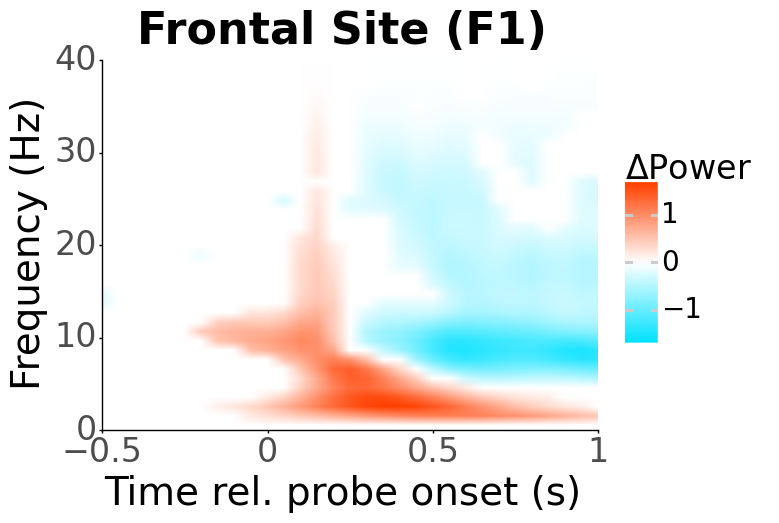

<ggplot: (1505463682)>

In [342]:
channel='F1'

chan_ROI = {
    'F1':'Frontal',
    'P1':'Parietal',
    'Cz':'Midfrontal',
    'C3':'Motor'
}

df_temp = df_tfEst[df_tfEst.channel.isin([channel])].copy()


df_temp.loc[(df_temp.pvals > 0.05),['pvals','tstat','betas']] = np.nan
# df_temp.loc[(df_temp.pvals > 0.0000416),['pvals','tstat','betas']] = np.nan



cmax = np.max(np.abs(df_tfEst.loc[df_tfEst.channel.isin([channel]),'betas'].values))
cmin = cmax*-1

# cmax = np.max((df_tfEst.loc[df_tfEst.channel.isin([channel]),'tstat'].values))
# cmin = np.min((df_tfEst.loc[df_tfEst.channel.isin([channel]),'tstat'].values))

p = (ggplot(df_temp,aes(x='time',y='frequency',fill='betas')) +
     geom_raster(interpolate=True)+
     ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_fill_gradient2(name='$\Delta$Power',
# #                             high = '#a6212c', # More muted
# #                           low = '#212ca6',
                          high = '#FF4000', # More vibrant
                          low = '#00E1FF',
                          mid = 'white',
                          na_value='white',
#                           mid='#7a6977',
#                           na_value='#7a6977',
                          limits=(cmin,cmax)) +
     scale_x_continuous(name='Time rel. probe onset (s)') +
     scale_y_continuous(name='Frequency (Hz)') +
     coord_cartesian(xlim = (-0.5,1), ylim = (0,40),expand=False)+
     theme_bw() +
#      guides(fill = guide_colourbar(direction='horizontal')) +
     theme(axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=24),
           axis_ticks_length = 2,
           axis_title = element_text(size=28),
           plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=20),
           legend_title = element_text(size=24),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

# p.save(savepath+'tfr/probeVno_'+channel+'_betas.svg')
# p.save(savepath+'tfr/probeVno_'+channel+'_betas.png')


p

### Unused: Movement vs FTI trials

In [415]:
## Run through and for each time/frequency/channel combination, estimate differences in power using a linear mixed-effects model.

df_temp = df[(df.time.between(-0.5,1)) & (df.condition.isin(['RP','FTI']))].copy()

df_temp['trialtype'] = df_temp.condition.isin(['RP']).values.astype('str')

df_temp

,Unnamed: 0,time,size,size_base,size_shift,size_base_shift,size_base_div,isprobe,isfti,wait_time,...,condition,brief,subject,trial,Cz,F1,C3,P1,freq,trialtype
30,30,-0.50,671.719152,-35.360741,735.952704,28.872811,-1.609044,0,0,2.901075,...,RP,True,33702,0,1.521677,4.118093,1.837226,1.725268,0.5,True
31,31,-0.45,670.279308,-36.800585,738.835103,31.755210,-1.674563,0,0,2.901075,...,RP,True,33702,0,1.653026,4.070239,1.718898,1.768906,0.5,True
32,32,-0.40,675.627623,-31.452270,738.944271,31.864378,-1.431195,0,0,2.901075,...,RP,True,33702,0,1.808007,4.148076,1.510348,1.889504,0.5,True
33,33,-0.35,685.048255,-22.031638,731.810970,24.731077,-1.002521,0,0,2.901075,...,RP,True,33702,0,2.141702,4.218228,1.281298,2.063245,0.5,True
34,34,-0.30,696.396098,-10.683795,725.951438,18.871545,-0.486152,0,0,2.901075,...,RP,True,33702,0,2.314389,4.355502,1.120632,2.249059,0.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10094275,56,0.80,497.462513,-105.456170,498.319217,-104.599465,-8.009888,0,0,3.559768,...,RP,True,33725,179,0.001115,0.093410,0.010687,0.011751,40.0,True
10094276,57,0.85,512.821678,-90.097005,500.678251,-102.240432,-6.843288,0,0,3.559768,...,RP,True,33725,179,0.000092,0.104674,0.004303,0.006332,40.0,True
10094277,58,0.90,526.893457,-76.025225,501.095534,-101.823149,-5.774470,0,0,3.559768,...,RP,True,33725,179,0.000112,0.069768,0.002067,0.003297,40.0,True
10094278,59,0.95,541.540112,-61.378571,499.398751,-103.519932,-4.661989,0,0,3.559768,...,RP,True,33725,179,0.000833,0.017470,0.005710,0.003455,40.0,True


In [416]:
frames = []

for time in df_temp.time.unique():
    print(time)
    for freq in df_temp.freq.unique():
        df_this = df_temp.loc[(df_temp.time==time)&(df_temp.freq==freq),chans2use+['time','trialtype','subject']].copy().dropna()
        
        betas = []
        pvals = []
        tstat = []
        chans = []
        for channel in chans2use:
#         for channel in ['Cz']:
        #     df_temp['logPow'] = np.log(df_temp[channel].values)
        #     model = Lmer('logPow~condition+(1|subject)',data=df_temp,)
            model = Lmer(channel+'~trialtype+(1|subject)',data=df_this)

            model.fit(factors={'trialtype':['True','False']},summary=False)

            betas.append(model.coefs['Estimate'][1])
            pvals.append(model.coefs['P-val'][1])
            tstat.append(model.coefs['T-stat'][1])
            chans.append(channel)

        df_tf = pd.DataFrame({
            'channel':chans,
            'betas':betas,
            'pvals':pvals,
            'tstat':tstat,
        })
        df_tf['time']=time
        df_tf['frequency'] = freq
        
        frames.append(df_tf)
    
df_tfEst = pd.concat(frames)

print('\n\n\nSaving to CSV')
df_tfEst.to_csv('processed_data/df_tfEst_rpVfti.csv',index=False)

-0.5
-0.45
-0.4000000000000001
-0.3500000000000001
-0.30000000000000004
-0.25
-0.2
-0.15000000000000013
-0.10000000000000007
-0.05000000000000005
0.0
0.05000000000000005
0.09999999999999988
0.1499999999999999
0.2
0.25
0.30000000000000004
0.3499999999999999
0.3999999999999999
0.45
0.5
0.5499999999999999
0.6
0.65
0.7
0.75
Model failed to converge with max|grad| = 0.00341374 (tol = 0.002, component 1) 

0.7999999999999999
0.85
0.9
0.95
1.0



Saving to CSV


In [418]:
df_tfEst = pd.read_csv('processed_data/df_tfEst_rpVfti.csv')

In [419]:
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.014553,0.006417,0.022689,0.004151,22.377484,3.505706,0.001959,**
trialtype1,-0.004325,-0.010525,0.001874,0.003163,2631.999631,-1.367352,0.171632,


In [338]:
# Note: > 0 means that probe trial is larger, < 0 means that RP trial is larger

min_ix = np.where(df_tfEst.tstat == np.min(df_tfEst.tstat.values))[0]
max_ix = np.where(df_tfEst.tstat == np.max(df_tfEst.tstat.values))[0]

print('Most significant probe > no: ',df_tfEst.iloc[max_ix,[0,2,4,5]])
print('Most significant no > probe: ',df_tfEst.iloc[min_ix,[0,2,4,5]])

Most significant probe > no:    channel          pvals  time  frequency
0      Cz  1.641409e-259   0.3   2.525641
Most significant no > probe:    channel         pvals  time  frequency
2      P1  4.480190e-23   0.6  13.666667


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/tfr/rpVfti_P1_betas.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/tfr/rpVfti_P1_betas.png


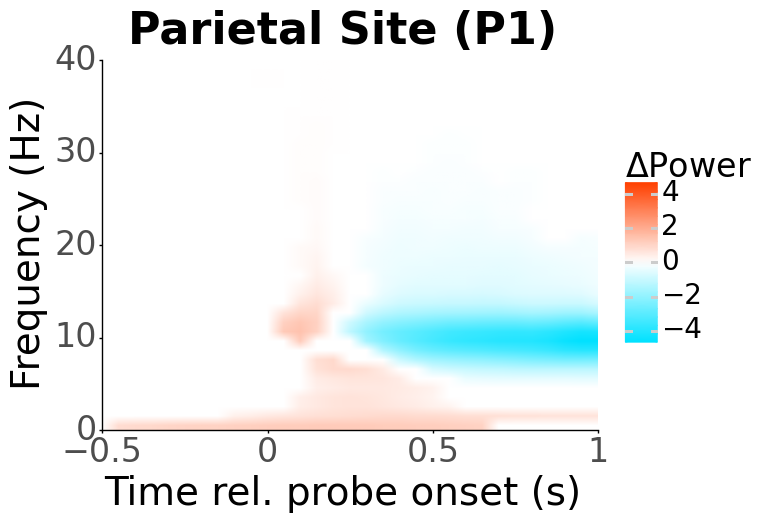

<ggplot: (455265052)>

In [423]:
channel='P1'

chan_ROI = {
    'F1':'Frontal',
    'P1':'Parietal',
    'Cz':'Midfrontal',
    'C3':'Motor'
}

df_temp = df_tfEst[df_tfEst.channel.isin([channel])].copy()


df_temp.loc[(df_temp.pvals > 0.05),['pvals','tstat','betas']] = np.nan
# df_temp.loc[(df_temp.pvals > 0.0000416),['pvals','tstat','betas']] = np.nan



cmax = np.max(np.abs(df_tfEst.loc[df_tfEst.channel.isin([channel]),'betas'].values))
cmin = cmax*-1

# cmax = np.max((df_tfEst.loc[df_tfEst.channel.isin([channel]),'tstat'].values))
# cmin = np.min((df_tfEst.loc[df_tfEst.channel.isin([channel]),'tstat'].values))

p = (ggplot(df_temp,aes(x='time',y='frequency',fill='betas')) +
     geom_raster(interpolate=True)+
     ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
     scale_fill_gradient2(name='$\Delta$Power',
# #                             high = '#a6212c', # More muted
# #                           low = '#212ca6',
                          high = '#FF4000', # More vibrant
                          low = '#00E1FF',
                          mid = 'white',
                          na_value='white',
#                           mid='#7a6977',
#                           na_value='#7a6977',
                          limits=(cmin,cmax)) +
     scale_x_continuous(name='Time rel. probe onset (s)') +
     scale_y_continuous(name='Frequency (Hz)') +
     coord_cartesian(xlim = (-0.5,1), ylim = (0,40),expand=False)+
     theme_bw() +
#      guides(fill = guide_colourbar(direction='horizontal')) +
     theme(axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=24),
           axis_ticks_length = 2,
           axis_title = element_text(size=28),
           plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=20),
           legend_title = element_text(size=24),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

p.save(savepath+'tfr/rpVfti_'+channel+'_betas.svg')
p.save(savepath+'tfr/rpVfti_'+channel+'_betas.png')


p